In [1]:
import onnx
import onnxruntime
import pandas as pd
import numpy as np
from timeit import default_timer as timer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load ONNX
## check onnx API

In [2]:
onnx_model = onnx.load("./MLP_trained_power.onnx")
onnx.checker.check_model(onnx_model)

## test model using onnxruntime

In [3]:
ort_session = onnxruntime.InferenceSession("./MLP_trained_power.onnx")
x = np.random.rand(9).astype(np.float32) # random generated here - use your inputs!
ort_inputs = {ort_session.get_inputs()[0].name: x}
ort_outputs = ort_session.run(None, ort_inputs)
ort_outputs[0]

array([ 7.0451759e-05,  3.5808887e-04, -1.7423443e-03, -1.3985857e-04,
        3.5959948e-03,  5.8714971e-03,  5.2851904e-03,  1.3407453e-02,
        8.6977063e-03,  5.5790115e-02,  2.4394687e-01,  2.9376420e-01,
        2.8586006e-01,  2.4681041e-01,  1.2581792e-01,  8.2657099e-02,
        4.7594227e-02,  2.1568649e-03, -3.4208577e-03,  2.5419751e-05,
        1.5672824e-03, -1.2695221e-03,  6.1402563e-04], dtype=float32)

# Example: 
## load test data

In [4]:
data = pd.read_csv("./hypercube_ecrit_filtered_80-20_split_5folds.csv")
test_data = data[data['split'] == 'TEST']

## normalize the test data 
input_features = ['B0_eqdsk', 'R0_eqdsk', 'ate0', 'dense0', 'elecfld', 'lh_npara1', 'lh_power', 'zeff', 'ip_scale']
ranges = ((2.5, 3.5), (1.8, 1.9), (1, 5), (1e19, 5e19), (-0.0001, 0.001), (1.7, 2.5), (1e5, 3e6), (1.5, 2.5), (0.5, 1.5))
feature_ranges = {f:r for f,r in zip(input_features,ranges)}

for feature in input_features: 
    min_, max_ = feature_ranges[feature]
    test_data[feature] = (test_data[feature] - min_) / (max_ - min_)

output_features =  ['powers_' + str(i) for i in range(23)]

/var/folders/sd/bvz9vdc525x99s2_byv93kv40000gn/T/ipykernel_9695/1217745049.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[feature] = (test_data[feature] - min_) / (max_ - min_)


## output prediction and inference time

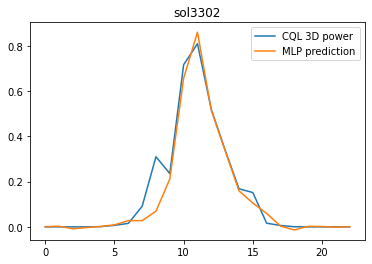

MSE value:  0.0031714850210358215


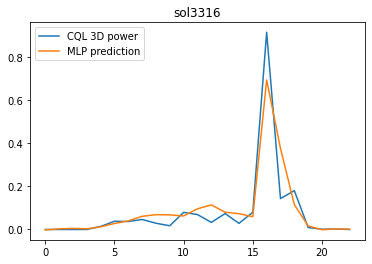

MSE value:  0.005315516271529675


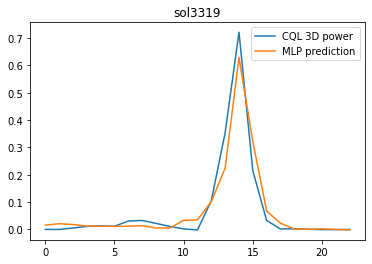

MSE value:  0.0018483463291871145


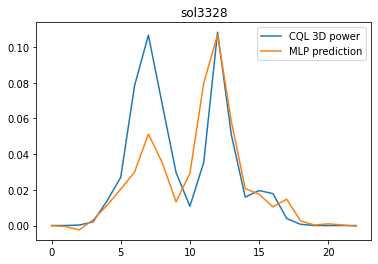

MSE value:  0.00040802665208137563


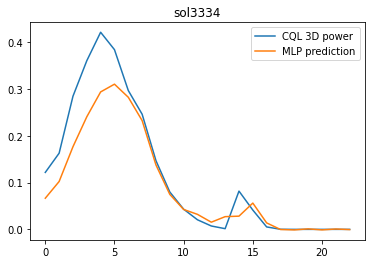

MSE value:  0.002557559428376415


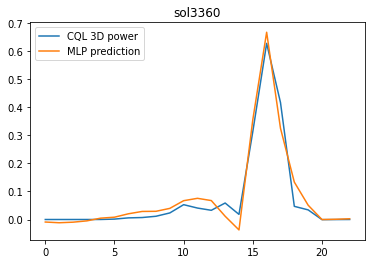

MSE value:  0.0012647276116072026


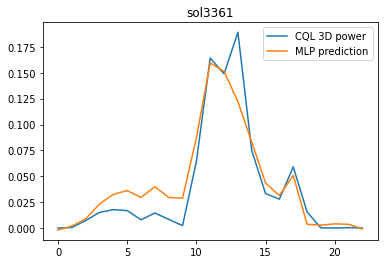

MSE value:  0.00036512239131329617


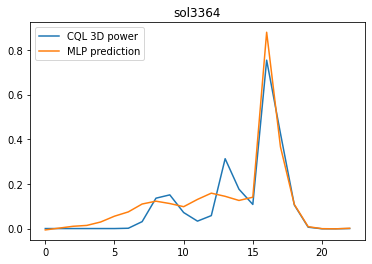

MSE value:  0.0038665728961186376


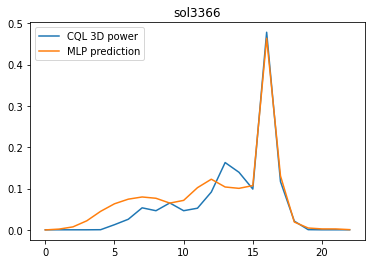

MSE value:  0.0008097069608079015


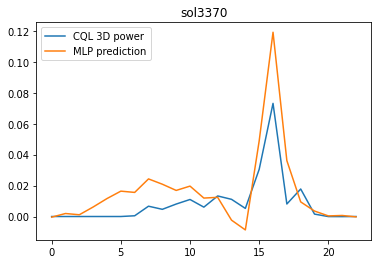

MSE value:  0.00022287194905513865
Averaged inferece time:  0.0006134155999999891


In [5]:
n = 10
t_elapsed = []

for index, sample in test_data.iloc[:n,:].iterrows():
    
    # parse data
    x = sample[input_features]
    y_true = np.array(sample[output_features])
    x = np.array(x).astype(dtype = 'float32')
    t0 = timer()
    
    # import input data and run onnx model
    ort_inputs = {ort_session.get_inputs()[0].name: x} 
    ort_outputs = ort_session.run(None, ort_inputs)
    # output predition
    y_pred = ort_outputs[0]
    t_elapsed.append(timer() - t0)
    
    # plot predictions
    plt.figure()
    plt.title(sample['sol'])
    plt.plot(y_true)
    plt.plot(y_pred) 
    plt.legend(['CQL 3D power', 'MLP prediction'])
    plt.show()
    print('MSE value: ', mean_squared_error(y_true, y_pred))
print('Averaged inferece time: ', np.sum(t_elapsed) / n)